# Two Traveling Salespeople

Name: Cody Lam

I understand that my submission needs to be my own work: yes

Points: 10

## Two-person Version of the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

* __Goal:__ Find the two tours which collectively visit each of $n$ cities exactly once and return back to the same starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$.

* __State space:__ Each state represents a pair of tours, where the first element of the pair are the cities to visit for the first person and the second element are the cities to visit for the second person. The cities are numbered and the tours can be expressed a pair of vectors $(\pi_1, \pi_2)$ with the order in which the cities are visited. That is, $\pi_i(1)$ is the index of the first city to visit by the $i$th person ($i$ either is 1 or 2), $\pi_i(2)$ the index of the second city to visit by the $i$th person, and so on.

* __Objective function:__ Minimize the maximum tour length for both people. Informally, the cities should be divided up roughly evenly between the two people so that neither one has a tour that is too long.

The optimization problem is to find the optimal pair of tours $\pi_1^*$ and $\pi_2^*$ through the $n$ cities and which return to the start cities of each tour:

  > minimize: $\max(\mathrm{tourlength}(\pi_1), \mathrm{tourlength}(\pi_2))$
  where $\mathrm{tourlength}(\pi_i) = d_{\pi_i(n),\pi_i(1)} + \sum_{j = 1}^{n-1} d_{\pi_i(j),\pi_i(j+1)}$
  >
  > subject to: every city must be visited exactly once


## Helper functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

np.set_printoptions(precision=2)

np.random.seed(0) # make the results repeatable

In [5]:
def random_tour_pair(n):
    """Create two random tours with n cities"""

    tour = list(range(n))
    np.random.shuffle(tour)

    split_index = np.random.randint(0, n-1)
    tour1 = tour[:split_index]
    tour2 = tour[split_index:]

    return tour1, tour2

random_tour_pair(10)

([4, 8, 1], [7, 9, 2, 0, 6, 5, 3])

In [6]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a
    pairwise Euclidean distance matrix.
    """

    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })

    dist = squareform(pdist(pos))

    return({"pos": pos, "dist": dist})

tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
          x         y
0  0.678880  0.135218
1  0.720633  0.324141
2  0.582020  0.149675
3  0.537373  0.222321
4  0.758616  0.386489
5  0.105908  0.902598
6  0.473600  0.449950
7  0.186332  0.613063
8  0.736918  0.902349
9  0.216550  0.099280
Distance matrix:
          0         1         2         3         4         5         6  \
0  0.000000  0.193482  0.097933  0.166166  0.263619  0.957690  0.375760   
1  0.193482  0.000000  0.222827  0.209646  0.073007  0.844097  0.277223   
2  0.097933  0.222827  0.000000  0.085269  0.295410  0.890829  0.319249   
3  0.166166  0.209646  0.085269  0.000000  0.275498  0.805568  0.236393   
4  0.263619  0.073007  0.295410  0.275498  0.000000  0.832104  0.291995   
5  0.957690  0.844097  0.890829  0.805568  0.832104  0.000000  0.583171   
6  0.375760  0.277223  0.319249  0.236393  0.291995  0.583171  0.000000   
7  0.686250  0.607415  0.609342  0.525270  0.615503  0.300497  0.330347   
8  0.769323  0.578437  0.768447  0.708700  0.516316  0.

In [9]:
def tour_pair_max_length(tsp, tour_pair):
   """Calculate the maximum length of a pair of tours, i.e., the objective function."""

   tour0_len = tour_length(tsp, tour_pair[0])
   tour1_len = tour_length(tsp, tour_pair[1])

   return max(tour0_len, tour1_len)

def tour_length(tsp, tour):
    """Caclulate the length of a single tour"""

    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()

    tl = 0
    dist = tsp["dist"]

    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]

    tl += dist[tour[-1], tour[0]]

    return(tl)

np.random.seed(0) # make the results repeatable
tour_pair = random_tour_pair(10)
print(f"objective value: {tour_pair_max_length(tsp, tour_pair)}")

objective value: 3.1007928939594622


Tour length (red): 2.27
Tour length (blue): 3.1


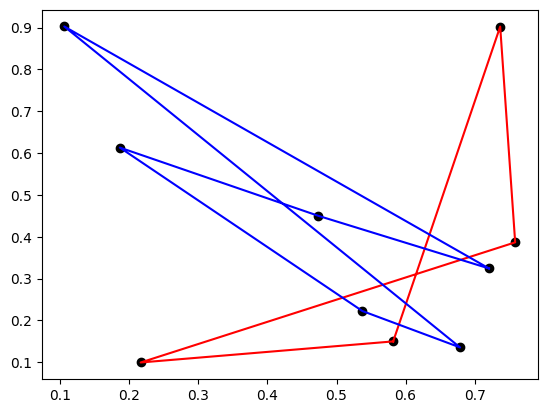

In [12]:
def show_2tsp(tsp, tour_pair = None):
    """display the twoperson traveling salesman problem and a tour pair."""

    pos = tsp["pos"]

    plt.scatter(pos["x"], pos["y"], color='black')

    if tour_pair is not None:
      colors = ['red', 'blue']

      for tour, color in zip(tour_pair, colors):
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): tour = tour.tolist()

        print(f"Tour length ({color}): {round(tour_length(tsp, tour), 2)}")
        tour_x_list = [pos.loc[i, 'x'] for i in tour]
        tour_y_list = [pos.loc[i, 'y'] for i in tour]

        # wrap back to start
        tour_x_list.append(tour_x_list[0])
        tour_y_list.append(tour_y_list[0])

        plt.plot(tour_x_list, tour_y_list, color)

    plt.show()

show_2tsp(tsp, tour_pair)

## Steepest-ascent Hill Climbing Search [2 Points]

Come up with reasonable definition for local moves and explain it in text. Implement a steepest-ascent hill climbing strategy. Measure and report the performance of this on 50 random problem instances. Report the average objective function reached over all problem instances, as well as the average number of local moves analyzed.

In [ ]:
# Code goes here

## Steepest-ascent Hill Climbing Search with Random Restarts [1 Point]

Modify the code to include random restarts once improvement is no longer possible. For a fixed problem instance, analyze the improvement in the objective function as more restarts are done. Plot the number of restarts on the x axis and the objective function on the y axis.

In [ ]:
# Code goes here

## Stochastic Hill Climbing [1 Point]

Implement an approach that chooses randomly from among all uphill moves. Measure and report the performance of this on the same 50 random problem instances as was done earlier. Report the average objective function reached over all problem instances, as well as the average number of local moves analyzed.

In [ ]:
# Code goes here

## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state. Implement this and report the performance of on 50 the same random problem instances. Report the average objective function reached over all problem instances, as well as the average number of local moves analyzed.

In [ ]:
# Code goes here

## Simulated Annealing [1 Point]

Implement an algorithm that uses simulated annealing to solve the problem, as described in the lectures and book (Section 4.1.2). Experiment with hyperparameters like the temperature schedule and thresholds until you find values that work well.

In [ ]:
# Code goes here

## Compare Performance [1 Point]

Compare simulated annealing with random restarts and stochastic hill climbing. Analyze which algorithm is better for 10 cities, 20 cities, and 50 cities. To make the comparison fair, try to ensure the time taken for each approach is roughly the same.

For timing you can use the `time` package.

In [ ]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

Do something
This took: 0.1678466796875 milliseconds


In [ ]:
# Code and results go here

## Tour US States [3 points]

Take your best performing approach for 50 cities and try to find the minimum objective value for a modified version of the two salesman problem going around the 48 lower US states. The modification is that both tours must start and end in New York. New York is the only state shared between the two tours.

Each state is considered visited if you can get to its centroid and it is assumed straight line distances between centroids based on GPS coordinates is the way we want to measure distances.

Plot the minimum objective value 2-tsp tours that you find in red and blue, like was done before for the randomly generated points. Print the length of the best tours, as well as the list of indices corresponding to states (Louisiana=0, Maryland=1, ... , see code below).

Loaded from states.pkl
[('Louisiana', 773189.1979394469, -1515002.377525561), ('Maryland', 1979094.0929296287, -383219.5841403244), ('Wisconsin', 789405.1598855292, 7178.093118233844), ('Florida', 1716480.2191801812, -1645210.600897309), ('Georgia', 1548181.6569137496, -1221152.92728593), ('Tennessee', 1227400.6102994615, -915322.7518723847), ('Minnesota', 437251.5679414956, 158022.4684412311), ('Iowa', 536318.2702880212, -303823.8620393781), ('Missouri', 657464.3949930624, -708334.2472004973), ('Michigan', 1154374.0876788201, 31062.850406589027), ('Idaho', -1153546.3198592367, 32306.322358552956), ('California', -1708049.274751084, -667730.6252787685), ('Connecticut', 2216157.7595848595, -1386.5813699763721), ('Texas', 66673.11730108206, -1502504.3982431893), ('Virginia', 1848871.780566167, -594407.8114616707), ('New York', 1957067.0071638965, 68085.33717547444), ('Illinois', 917185.1983259161, -491248.59737063444), ('Montana', -727314.0192655406, 271896.712857685), ('Kentucky', 12904

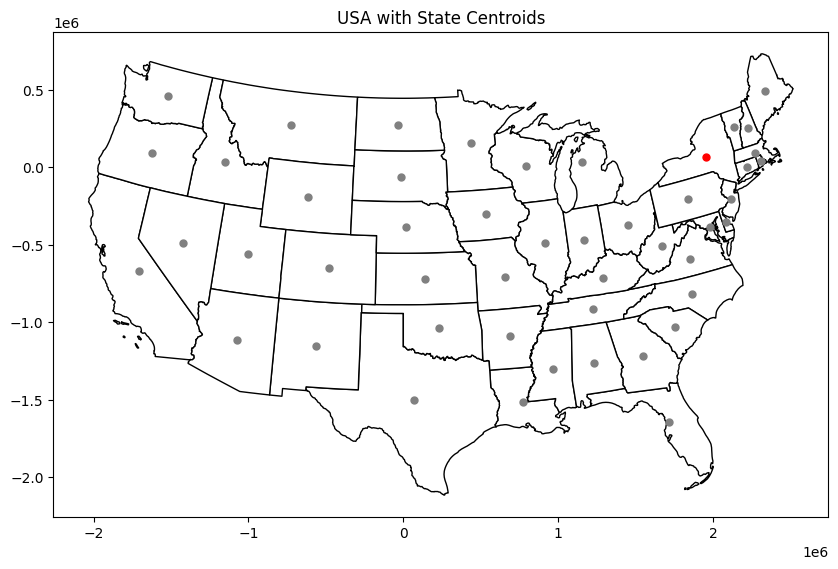

In [ ]:
import geopandas as gpd

def get_state_centroids():

    # load pickled data from states.pkl if it exists
    try:
        states = pd.read_pickle('states.pkl')
        print('Loaded from states.pkl')
    except:
        states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip')

        # pickle (save) the data to states.pkl so we don't need to download in the future
        states.to_pickle('states.pkl')

        print('Downloaded data and saved to states.pkl')

    # Filter out Alaska, Hawaii, and territories
    contiguous_usa = states[~states['STUSPS'].isin(['AK', 'HI', 'PR', 'GU', 'VI', 'MP', 'AS', 'DC'])]

    # Get centroid data
    contiguous_usa = contiguous_usa.to_crs(epsg=2163)
    centroids = contiguous_usa.geometry.centroid
    contiguous_usa['centroid_lon'] = centroids.x
    contiguous_usa['centroid_lat'] = centroids.y

    # Create tuples (state name, x-coordinate, y-coordinate)
    state_tuples = list(zip(contiguous_usa['NAME'], centroids.x, centroids.y))

    return contiguous_usa, state_tuples

def draw_contiguous_usa_map_with_centroids():
    contiguous_usa, state_tuples = get_state_centroids()

    print(state_tuples)
    print(len(state_tuples))

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    contiguous_usa.plot(ax=ax, color='white', edgecolor='black')

    # Plot centroids
    for statename, x, y in state_tuples:
        color = 'red' if statename == 'New York' else 'grey'
        plt.plot(x, y, marker='o', color=color, markersize=5)

    plt.title("USA with State Centroids")
    plt.show()

draw_contiguous_usa_map_with_centroids()



---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
